In [1]:
%matplotlib notebook

import json
import numpy as np
import numpy.random as npr
import scipy.stats as scs
import matplotlib.pyplot as plt
import matplotlib.ticker as mpt

from ast import literal_eval

In [2]:
BURN_IN = 20

base_parameters = {
    'k_a': 0.002,
    'k_d': 0.1,
    'mu': 3.0,
    'kappa': 1.0,
    'gamma': 0.04,
    'diffusion': 0.6,
    'time_step': 0.1,
    'cell_radius': 6.0,
    'nucleus_radius': 2.5,
}

def log_value(p, name=None):
    return (np.log10(base_parameters[name]) if name else 0) + p * np.log10(2)

def exp_value(p, name=None):
    return (p - (np.log10(base_parameters[name]) if name else 0))/np.log10(2)

<IPython.core.display.Javascript object>


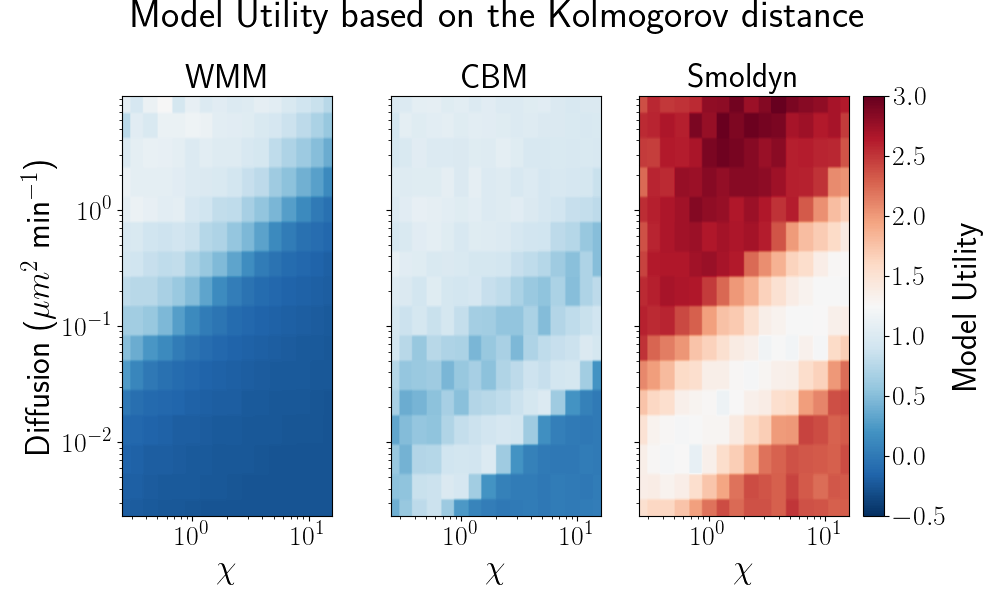

In [3]:
params = {'legend.fontsize': 20,
         'figure.figsize': (10, 6),
         'figure.titlesize': 28,
         'axes.labelsize': 24,
         'axes.titlesize':24,
         'xtick.labelsize':20,
         'ytick.labelsize':20,
         'text.usetex':True,
         'figure.autolayout':True,
         }

plt.rcParams.update(params)

import scipy.interpolate as sci
import matplotlib.colors as colors

for filename in [
    '../kg/utility_kg_all_hh.json',
]:
    with open(filename, 'r') as f:
        data = {literal_eval(k): v for k, v in json.load(f).items()}

    fig, ax = plt.subplots(1, 3, sharex=True, sharey=True)
    #fig.tight_layout(w_pad=0)

    for i, solver in enumerate(['WMM', 'CBM', 'smoldyn']):
        min_x = log_value(min(data.keys(), key=lambda t: t[1])[1])
        max_x = log_value(max(data.keys(), key=lambda t: t[1])[1])
        min_D = log_value(min(data.keys(), key=lambda t: t[0])[0], 'diffusion')
        max_D = log_value(max(data.keys(), key=lambda t: t[0])[0], 'diffusion')

        raw_grid = np.array([[log_value(chi), log_value(D, 'diffusion'), utility[solver]]
                             for ((D, chi, k_d), utility) in data.items()
                            if k_d == 0])

        XY = raw_grid[:, :2]
        Z = raw_grid[:, 2]

        xi, yi = np.mgrid[min_x:max_x:100j, min_D:max_D:100j]
        grid_z2 = sci.griddata(XY, Z, (xi, yi) , method='nearest')

        pcm = ax[i].imshow(grid_z2.T, extent=(min_x, max_x, min_D, max_D),
                   vmin=-0.5, vmax=3,
                   origin='lower', cmap='RdBu_r')

        if not i:
            ax[i].set_ylabel('Diffusion ($\mu m^2$ min$^{-1}$)')

        ax[i].set_xlabel('$\chi$')

        ax[i].set_title(f"{solver if solver != 'smoldyn' else 'Smoldyn'}")

        xticks = list(range(int(np.ceil(min_x)), int(np.floor(max_x))+1))
        ax[i].set_xticks(xticks)
        ax[i].set_xticklabels([f'$10^{{{t}}}$' for t in xticks])
        ax[i].xaxis.set_minor_locator(mpt.FixedLocator(sum([[np.log10(i*c) for i in range(2,10)] for c in [0.001, 0.01, 0.1, 1, 10]],[])))

        yticks = list(range(int(np.ceil(min_D)), int(np.floor(max_D))+1))
        ax[i].set_yticks(yticks)
        ax[i].set_yticklabels([f'$10^{{{t}}}$' for t in yticks])
        ax[i].yaxis.set_minor_locator(mpt.FixedLocator(sum([[np.log10(i*c) for i in range(2,10)] for c in [0.001, 0.01, 0.1, 1, 10]],[])))

    cb = fig.colorbar(pcm, shrink=1)
    cb.set_label('Model Utility')
    
    fig.suptitle("Model Utility based on the Kolmogorov distance", y=1)
    plt.tight_layout()
    plt.savefig(f"modelutility.pdf", bbox_inches='tight')